# Generate TensorRT Engines from Tensorflow (or other UFF Compatable Frameworks)

TensorRT 3.0.4 includes the UFF (Universal Framework Format) parser, a way to import UFF models and generate TensorRT engines. The UFF Toolkit which was released with TensorRT 3.0 provides support for converting Tensorflow models to UFF, there by allowing Tensorflow users to access the performace gains of TensorRT. With the Python API you can now go from training in Tensorflow to deploying in TensorRT without leaving Python. 

For this example, we are going to train a LeNet5 model to classify handwritten digits and then generate a TensorRT Engine for inference.  

For python the TensorRT library is refered to as ```tensorrt```, for the Early Access you should have been provided a wheel file with the API, this can be installed by using ```pip``` (e.g. for python2.7 - ```pip install tensorrt-3.0.4-cp27-cp27mu-linux_x86_64.whl```). For the Release Canidate forward you can also install the Python API with ```apt-get``` (```apt-get install python-tensorrt```)

We need to import Tensorflow and its various packages (note: there is a know bug in the EA where Tensorflow needs to be imported before TensorRT, this will addressed in the RC) 

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

We can import TensorRT and its parsers like so:

In [2]:
import tensorrt as trt
from tensorrt.parsers import uffparser

There are also some common tools that are used with tensorrt typically. We use PyCUDA to handle the CUDA operations needed to allocate memory on your GPU and to transfer data to the GPU and results back to the CPU. We also use numpy as our primary method to store data

In [3]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
from random import randint # generate a random test case
from PIL import Image
from matplotlib.pyplot import imshow #to show test case
import time #import system tools
import os

Finally we need to import the UFF toolkit to convert the graph from a serialized frozen tensorflow model to UFF

In [4]:
import uff

## Training a Model in Tensorflow 

We are going to move quickly through the Tensorflow component ofthis example since its not the focus. If you want to learn more about Tensorflow and how to use it, checkout https://www.tensorflow.org/get_started/get_started

We are going to start by defining some hyper parameters, then defining some helper functions to make the code a bit less verbose. We will then define a network, then define our loss metrics, training and test steps our input nodes, and a data loader. 

In [5]:
STARTER_LEARNING_RATE = 1e-4
BATCH_SIZE = 10
NUM_CLASSES = 10
MAX_STEPS = 3000
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE ** 2
OUTPUT_NAMES = ["fc2/Relu"]

*Notice that we are padding our Conv2d layer. TensorRT expects symetric padding for layers*

In [6]:
def WeightsVariable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1, name='weights'))

def BiasVariable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape, name='biases'))

def Conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    filter_size = W.get_shape().as_list()
    pad_size = filter_size[0]//2
    pad_mat = np.array([[0,0],[pad_size,pad_size],[pad_size,pad_size],[0,0]])
    x = tf.pad(x, pad_mat)
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def MaxPool2x2(x, k=2):
    # MaxPool2D wrapper
    pad_size = k//2
    pad_mat = np.array([[0,0],[pad_size,pad_size],[pad_size,pad_size],[0,0]])
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')


In [7]:
def network(images):
    # Convolution 1
    with tf.name_scope('conv1'):
        weights = WeightsVariable([5,5,1,32])
        biases = BiasVariable([32])
        conv1 = tf.nn.relu(Conv2d(images, weights, biases))
        pool1 = MaxPool2x2(conv1)

    # Convolution 2
    with tf.name_scope('conv2'):
        weights = WeightsVariable([5,5,32,64])
        biases = BiasVariable([64])
        conv2 = tf.nn.relu(Conv2d(pool1, weights, biases))
        pool2 = MaxPool2x2(conv2)
        pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Fully Connected 1
    with tf.name_scope('fc1'):
        weights = WeightsVariable([7 * 7 * 64, 1024])
        biases = BiasVariable([1024])
        fc1 = tf.nn.relu(tf.matmul(pool2_flat, weights) + biases)

    # Fully Connected 2
    with tf.name_scope('fc2'):
        weights = WeightsVariable([1024, 10])
        biases = BiasVariable([10])
        fc2 = tf.nn.relu(tf.matmul(fc1, weights) + biases)

    return fc2


In [8]:
def loss_metrics(logits, labels):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, 
                                                                   logits=logits, 
                                                                   name='softmax')
    return tf.reduce_mean(cross_entropy, name='softmax_mean')

In [9]:
def training(loss):
    tf.summary.scalar('loss', loss)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    learning_rate = tf.train.exponential_decay(STARTER_LEARNING_RATE, 
                                               global_step, 
                                               100000, 
                                               0.75, 
                                               staircase=True)
    tf.summary.scalar('learning_rate', learning_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op

In [10]:
def evaluation(logits, labels):
    correct = tf.nn.in_top_k(logits, labels, 1)
    return tf.reduce_sum(tf.cast(correct, tf.int32))

In [11]:
def do_eval(sess,
            eval_correct,
            images_placeholder,
            labels_placeholder,
            data_set,
            summary):

    true_count = 0
    steps_per_epoch = data_set.num_examples // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    for step in range(steps_per_epoch):
        feed_dict = fill_feed_dict(data_set,
                                   images_placeholder,
                                   labels_placeholder)
        log, correctness = sess.run([summary, eval_correct], feed_dict=feed_dict)
        true_count += correctness
    precision = float(true_count) / num_examples
    tf.summary.scalar('precision', tf.constant(precision))
    print('Num examples %d, Num Correct: %d Precision @ 1: %0.04f' % 
          (num_examples, true_count, precision))
    return log

In [12]:
def placeholder_inputs(batch_size):
    images_placeholder = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
    labels_placeholder = tf.placeholder(tf.int32, shape=(None))
    return images_placeholder, labels_placeholder


In [13]:
def fill_feed_dict(data_set, images_pl, labels_pl):
    images_feed, labels_feed = data_set.next_batch(BATCH_SIZE)
    feed_dict = {
        images_pl: np.reshape(images_feed, (-1,28,28,1)),
        labels_pl: labels_feed,
    }
    return feed_dict


We are going to define our training pipeline in function that will return a frozen model with the training nodes removed

In [14]:
def run_training(data_sets):
    with tf.Graph().as_default():
        images_placeholder, labels_placeholder = placeholder_inputs(BATCH_SIZE)
        logits = network(images_placeholder)
        loss = loss_metrics(logits, labels_placeholder)
        train_op = training(loss)
        eval_correct = evaluation(logits, labels_placeholder)
        summary = tf.summary.merge_all()
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        summary_writer = tf.summary.FileWriter("/tmp/tensorflow/mnist/log", 
                                               graph=tf.get_default_graph())
        test_writer = tf.summary.FileWriter("/tmp/tensorflow/mnist/log/validation",  
                                            graph=tf.get_default_graph())
        sess.run(init)
        for step in range(MAX_STEPS):
            start_time = time.time()
            feed_dict = fill_feed_dict(data_sets.train,
                                       images_placeholder,
                                       labels_placeholder)
            _, loss_value = sess.run([train_op, loss], feed_dict=feed_dict)
            duration = time.time() - start_time
            if step % 100 == 0:
                print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
                summary_str = sess.run(summary, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, step)
                summary_writer.flush()
            if (step + 1) % 1000 == 0 or (step + 1) == MAX_STEPS:
                checkpoint_file = os.path.join("/tmp/tensorflow/mnist/log", "model.ckpt")
                saver.save(sess, checkpoint_file, global_step=step)
                print('Validation Data Eval:')
                log = do_eval(sess,
                              eval_correct,
                              images_placeholder,
                              labels_placeholder,
                              data_sets.validation,
                              summary)
                test_writer.add_summary(log, step)
        #return sess

        graphdef = tf.get_default_graph().as_graph_def()
        frozen_graph = tf.graph_util.convert_variables_to_constants(sess, 
                                                                    graphdef, 
                                                                    OUTPUT_NAMES)
        return tf.graph_util.remove_training_nodes(frozen_graph)


Now we are going to load the Tensorflow MNIST data loader and run training, the model does have summaries included so you can take at look at the training in tensorboard.

In [15]:
MNIST_DATASETS = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data')
tf_model = run_training(MNIST_DATASETS)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Step 0: loss = 5.63 (1.232 sec)
Step 100: loss = 2.33 (0.003 sec)
Step 200: loss = 2.30 (0.003 sec)
Step 300: loss = 1.98 (0.003 sec)
Step 400: loss = 2.10 (0.003 sec)
Step 500: loss = 1.86 (0.002 sec)
Step 600: loss = 2.08 (0.002 sec)
Step 700: loss = 1.81 (0.003 sec)
Step

## Convert a Tensorflow Model to UFF
We are now going to convert it into a serialized UFF model. To convert a model we need to at least provide the model stream and the name(s) of the desired output node(s). The UFF Toolkit also includes a ```uff.from_tensorflow_frozen_model``` function which takes a path to a frozen Tensorflow graph protobuf file. Both utilities have options for:
- ```quiet``` mode to suppress conversion logging
- ```input_nodes``` to allow you to define a set of input nodes in the graph (the defaults are Placeholders nodes)
- ```text``` will let you save a human readable version of UFF model aloneside the binary UFF
- ```list_nodes``` will list the nodes in the graph 
- ```output_filename``` will if provided write the model out to the filepath specified instead of returning a serialized model

In [16]:
uff_model = uff.from_tensorflow(tf_model, ["fc2/Relu"])

Using output node fc2/Relu
Converting to UFF graph
No. nodes: 28


## Import a UFF Model into TensorRT and Create an Engine 

We now have a UFF modelsteam we can generate a TensorRT engine with. We are going to start by creating a logger for TensorRT.

In [17]:
G_LOGGER = trt.infer.ConsoleLogger(trt.infer.LogSeverity.ERROR)

Next we are going to create a uff parser and identifying the desired input and output nodes

In [18]:
parser = uffparser.create_uff_parser()
parser.register_input("Placeholder", (1,28,28), 0)
parser.register_output("fc2/Relu")

True

Now we are going to pass the logger, parser and the uff model stream and some settings (max batch size and max workspace size) to a utility function that will create the engine for us

In [19]:
engine = trt.utils.uff_to_trt_engine(G_LOGGER, uff_model, parser, 1, 1 << 20)

Now we need to allocate some memory on the CPU to use while we have an active engine 

We can now get rid of the parser

In [20]:
parser.destroy()

Now we are going to get a test case from the Tensorflow dataloader (converting it to FP32)

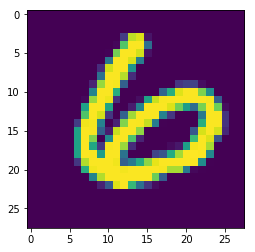

In [21]:
img, label = MNIST_DATASETS.test.next_batch(1)
img = img[0]
#convert input data to Float32
img = img.astype(np.float32)
label = label[0]
%matplotlib inline
imshow(img.reshape(28,28))

We are now going to create a runtime and an execution context for the engine

In [22]:
runtime = trt.infer.create_infer_runtime(G_LOGGER)
context = engine.create_execution_context()

We are going to now allocate the memory on the GPU and allocate memory on the CPU to hold results after inference. The size of the allocations is the size of the input and expected output * the batch size. 

In [23]:
output = np.empty(10, dtype = np.float32)

#alocate device memory
d_input = cuda.mem_alloc(1 * img.size * img.dtype.itemsize)
d_output = cuda.mem_alloc(1 * output.size * output.dtype.itemsize)

The engine needs bindings provided as pointers to the GPU memory. PyCUDA lets us do this for memory allocations by casting those allocations to ints

In [24]:
bindings = [int(d_input), int(d_output)] 

We also are going to create a cuda stream to run inference in.

In [25]:
stream = cuda.Stream()

Now we are going to transfer the data to the GPU, run inference and the copy the results back.

In [26]:
#transfer input data to device
cuda.memcpy_htod_async(d_input, img, stream)
#execute model 
context.enqueue(1, bindings, stream.handle, None)
#transfer predictions back
cuda.memcpy_dtoh_async(output, d_output, stream)
#syncronize threads
stream.synchronize()

Now we have our results. We can just run ArgMax to get a prediction

In [27]:
print("Test Case: " + str(label))
print ("Prediction: " + str(np.argmax(output)))

Test Case: 6
Prediction: 0


We can also save our engine to a file to use later

In [28]:
trt.utils.write_engine_to_file("./tf_mnist.engine", engine.serialize()) 

True

You can then load this engine later by using ```tensorrt.utils.load_engine```

In [29]:
new_engine = trt.utils.load_engine(G_LOGGER, "./tf_mnist.engine") 

And as a final step, we are going to clean up our context, engine and runtime

In [30]:
context.destroy()
engine.destroy()
new_engine.destroy()
runtime.destroy()